In [1]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
 
plt.rcParams.update({'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

print(tf.__version__)

2.2.0


In [2]:
import pae.load_data as ld
load_funcs=dict(mnist=ld.load_mnist, fmnist=ld.load_fmnist, celeba=ld.load_celeba)

In [3]:
from pae.fid_score_tf2 import *

In [4]:
PROJECT_PATH = "../../" 
PARAMS_PATH = os.path.join(PROJECT_PATH,'params')
param_file = 'params_fmnist_-1_32_infoGAN_VAE_v2_full_sigma_beta100_C15'
params      = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

In [6]:
if not os.path.isdir(params['plot_dir']):
    os.makedirs(params['plot_dir'])
if not os.path.isdir(params['data_dir']):
    os.makedirs(params['data_dir'])

In [7]:
load_func                                          = load_funcs[params['data_set']]
x_train, y_train, x_valid, y_valid, x_test, y_test = load_func(params['data_dir'])

if np.all(x_test)==None:
    x_test=x_valid

x_train    = x_train/255.-0.5
x_test     = x_test/255.-0.5
x_valid    = x_valid/255.-0.5


In [8]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')

In [9]:
shape = params['data_shape']
shape = np.append(-1,shape)
print(shape)

x_valid = np.reshape(x_valid, shape)

[-1 28 28  1]


In [10]:
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [11]:
tf.reset_default_graph()

data          = tf.placeholder(shape=[None]+params['data_shape'],dtype=tf.float32)
latent_point  = tf.placeholder(shape=[None,params['latent_size']],dtype=tf.float32)
sample_size   = tf.placeholder_with_default(params['batch_size'], shape=[])
encoder       = hub.Module(encoder_path, trainable=False)
decoder       = hub.Module(generator_path, trainable=False)

prior         = tfd.MultivariateNormalDiag(tf.zeros(params['latent_size']), scale_identity_multiplier=1.0)

encoded, _    = tf.split(encoder({'x':data},as_dict=True)['z'], 2, axis=-1)
decoded       = decoder({'z':encoded},as_dict=True)['x']

decoded_latent= decoder({'z':latent_point},as_dict=True)['x']

sigma         = tf.reduce_mean(tf.sqrt(tf.square(data-decoded)),axis=0)

samples         = prior.sample(sample_size)
decoded_samples = decoder({'z':samples},as_dict=True)['x']

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [13]:
rec, d            = sess.run([decoded,data], feed_dict={data:x_valid[0:params['batch_size']]})
recs=[]
delta = len(x_valid)%params['batch_size']
for ii in range(len(x_valid)//params['batch_size']):
    recs+=[sess.run(decoded, feed_dict={data:x_valid[ii*params['batch_size']:(ii+1)*params['batch_size']]})]
data_sample=np.concatenate((x_valid[(ii+1)*params['batch_size']:len(x_valid)],x_valid[0:params['batch_size']-delta]))
recs+=[sess.run(decoded, feed_dict={data:data_sample})]
recs = np.asarray(recs).reshape(shape)[0:len(x_valid)]



In [14]:
recs.shape

(10000, 28, 28, 1)

In [15]:
full_sigma = np.sqrt(np.mean(np.square(x_valid-recs),axis=0))
mean_sigma = np.mean(full_sigma)
mean_var   = np.mean(full_sigma**2)
# plt.figure()
# plt.title('pixel-wise variance')
# plt.imshow((full_sigma**2).reshape([64,64,3]), cmap='gray')
# plt.colorbar()
# plt.axis('off')
# plt.savefig(os.path.join(params['plot_dir'],'measured_sigma.pdf'),bbox_inches='tight')
# plt.show()
params['full_sigma']=full_sigma
pickle.dump(params,open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'wb'))
print('mean variance', mean_var)
print('minimum variance', np.min(full_sigma**2))
print('maximal variance', np.max(full_sigma**2))

mean variance 0.0128833226791111
minimum variance 1.5204627227987211e-06
maximal variance 0.03270487410478781


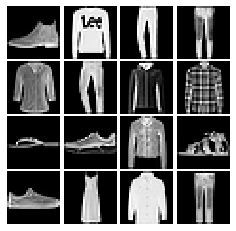

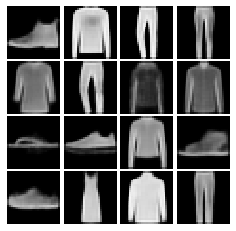

In [16]:

jj=1
plt.figure(figsize=(4,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((d[ii]+0.5)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'orig_valid_set.pdf'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(4,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze(rec[ii]+0.5),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')

plt.savefig(os.path.join(params['plot_dir'],'rec_valid_set.pdf'),bbox_inches='tight')
plt.show()

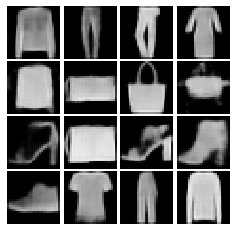

In [17]:
random_samples=[]
for ii in range(10000//params['batch_size']+1):
    random_samples+=[sess.run(decoded_samples)]
random_samples=np.asarray(random_samples).reshape(shape)[0:10000]

plt.figure(figsize=(4,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((random_samples[ii]+0.5)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'raw_samples.pdf'),bbox_inches='tight')
plt.show()

In [18]:
def evaluate_fid_score(fake_images, real_images,norm=True):
    #np.random.shuffle(real_images)
    assert(len(real_images))
    assert(len(fake_images))
    real_images = real_images[0:10000]
    fake_images = fake_images[0:10000]
    real_images = preprocess_fake_images(real_images, norm)
    fake_images = preprocess_fake_images(fake_images, norm)
    print(real_images.shape)
    inception_path = check_or_download_inception()

    create_inception_graph(inception_path)
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())

    print('calculating tf features...')
    real_out = get_activations_tf(real_images, sess)
    fake_out = get_activations_tf(fake_images, sess)
    fid_result = fid_score(real_out, fake_out)

    return fid_result

In [19]:
evaluate_fid_score(random_samples,x_valid)

norm =  True
norm =  True
(10000, 28, 28, 3)
Instructions for updating:
Use tf.gfile.GFile.
calculating tf features...


56.4733481066089

In [20]:
evaluate_fid_score(recs,x_valid)

norm =  True
norm =  True
(10000, 28, 28, 3)


/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


calculating tf features...


51.276299431164574